Here is the Dijkstra's Shortest Path Algorithm put into Python. The purpose of this algorithm is to find the shortest path from one node to any other node.

Pros:
1. Determines shortest path to destination (Traveling Salesman)
2. Can show shortest path to other nodes
3. Determines distance with Earth curvature in mind

Cons:
4. Not useful/accurate to show distance if not starting from the origin the algo was ran on
5. Does not include any constraints (at least for default)

Step 1: Let's randomly generate 20 nodes and pick one at random to do our analysis. Let's also make some of the node connections based. Unfortunately, it's possible with my generation that not all nodes will connect to each other so if that happens, run again. In practice, you'll know the possible connections between nodes but for our purpose, we're just generating some for each test.

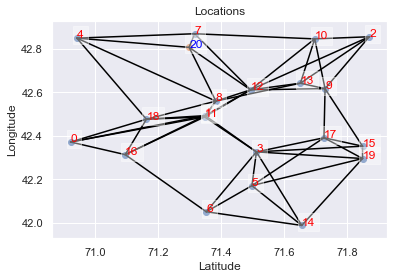

See above for all possible connections of nodes in our network! In practice, possible node conenctions would be known!


,Lat,Long
0,42.371671,70.923257
1,42.493252,71.349550
2,42.856677,71.869072
3,42.326242,71.511788
4,42.850395,70.943214
5,42.170690,71.497563
6,42.050347,71.353069
7,42.870559,71.316066
8,42.560177,71.383387
9,42.617432,71.729142


In [467]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

#set seaborn
sns.set()

#Set # of Nodes to randomly generate (because all nodes are random, let's make 20 our node of interest)
n = 21
origin = 21
maxConnect = 4
minConnect = 2

#Get our destinations around center (randomly generated)
centered = np.array([42.4072, 71.3824]) #LatLong of our DC in Massachusetts
destinations = np.random.random((n,2)) -.5 + centered #For example, get 21 nodes around center
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})

#Make function to determine distance between two LatLongs
def latlongdiff(destination1, destination2):
    destination1 = destination1 * (math.pi/180) #LatLong should alreay be in degrees
    destination2 = destination2 * (math.pi/180)
    desDiff = 3959*(math.acos(math.sin(destination1[0]) * math.sin(destination2[0]) + 
                            math.cos(destination1[0]) * math.cos(destination2[0]) *
                            math.cos(destination1[1] - destination2[1])))
    return desDiff

#Let's get distance between each node:
combos = list(itertools.combinations(list(range(n)),2))
distTup = []
distBet = []

for i, j in combos:
    distTup.append((i,j))
    distBet.append(latlongdiff(df.iloc[i,0:2], df.iloc[j,0:2]))

#In an actual experiment, you'd know which nodes can connect to which nodes, for our purposes, the
#below code is a random convention that gave favorable connections between max and min connections
combos = pd.DataFrame(list(zip(distTup,distBet)), columns=["DistTuple", "DistBetween"]).sort_values("DistBetween")
connections = pd.DataFrame(columns=["DistTuple", "DistBetween"])
for index, i in combos.iterrows():
    if i["DistBetween"] <= combos.quantile(1/n)[0]+combos.std()[0]:
        connections = connections.append(i)
check = Counter(connections["DistTuple"].str.get(0))+Counter(connections["DistTuple"].str.get(1))
connections = pd.DataFrame(columns=["DistTuple", "DistBetween"])
for i in df.index:
    comblist = combos[(combos["DistTuple"].str.get(0)==i) | (combos["DistTuple"].str.get(1)==i)]
    if i not in check.keys() or check[i] < minConnect:
        connections = connections.append(comblist.iloc[:minConnect])
    else:
        connections = connections.append(comblist.iloc[:maxConnect])
connections = connections.drop_duplicates().sort_values("DistBetween").reset_index(drop=True)

#Make a plot of starting data
plt.scatter(destinations[:-1,1], destinations[:-1,0])
plt.scatter(destinations[-1,1], destinations[-1,0])
for i, j in connections["DistTuple"]:
    plt.plot([df.loc[i,"Long"],df.loc[j,"Long"]], [df.loc[i,"Lat"],df.loc[j,"Lat"]], c= "black")
for i in df.index:
    if i == origin -1:
        plt.text(df.iloc[i,1], df.iloc[i,0], i, fontsize=12, c="blue",
             zorder = 20, bbox=dict(facecolor='white', alpha=0.4))
    else:
        plt.text(df.iloc[i,1], df.iloc[i,0], i, fontsize=12, c="red",
             zorder = 20, bbox=dict(facecolor='white', alpha=0.4))
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title('Locations')
plt.show()

print("See above for all possible connections of nodes in our network! In practice, possible node conenctions would be known!")
df


Step 2: Let's run the algorithm to find the closest paths from our starting node (which we picked as node 20). 

In [468]:
#Make needed columns and initialize
df["L"] = combos["DistBetween"].max() * n ** 2 #Should start as infinity but this should work
df["S"] = False #Determines if node was visited yet, all start as 0
df["P"] = "" #Meant to retain the preceding node whose value is attributed in L
df.loc[origin-1,["L", "S"]] = [0, True]

#Let's do our analysis now
connections_ = connections
check_ = list(check.keys())
while len(connections_) > 0:
    si = df[df["L"]==(df[df["S"] & df.index.isin(check_)]["L"].min())]
    sii = si.index.values[0]
    check_.remove(sii)
    connlist = connections_[(connections_["DistTuple"].str.get(0)==sii) | (connections_["DistTuple"].str.get(1)==sii)]#######  
    connections_ = connections_.drop(connlist.index)
    for i in range(len(connlist)):
        if connlist.iloc[i,0][0] == sii:
            nextsii = connlist.iloc[i,0][1]
        else:
            nextsii = connlist.iloc[i,0][0]
        if df.loc[nextsii,"L"] < df.loc[sii,"L"] + connlist.iloc[i,1]:
            pass
        else:
            df.loc[nextsii,"L"] = df.loc[sii,"L"] + connlist.iloc[i,1]
            df.loc[nextsii,"S"] = True
            df.loc[nextsii,"P"] = sii 

df


,Lat,Long,L,S,P
0,42.371671,70.923257,44.484078,True,18
1,42.493252,71.349550,22.580831,True,8
2,42.856677,71.869072,32.528129,True,10
3,42.326242,71.511788,36.782239,True,1
4,42.850395,70.943214,18.253681,True,20
5,42.170690,71.497563,47.555113,True,3
6,42.050347,71.353069,57.505514,True,3
7,42.870559,71.316066,4.420977,True,20
8,42.560177,71.383387,17.645923,True,20
9,42.617432,71.729142,28.753774,True,12


Step 3: let's visualize our shortest path from the starting node 20

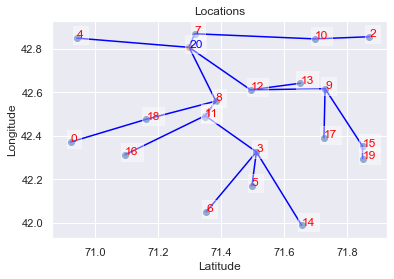

Please see above for the output! The blue path shows the shortest path from the origin (20) to any other node given all possible (black line) connections!


In [470]:
#Let's change our scatter plot so the shortest path is blue
plt.scatter(destinations[:-1,1], destinations[:-1,0])
plt.scatter(destinations[-1,1], destinations[-1,0])
for i in df.itertuples():
    if i[5] == "":
        continue
    else:
        plt.plot([df.loc[i[0],"Long"],df.loc[i[5],"Long"]], [df.loc[i[0],"Lat"],df.loc[i[5],"Lat"]], c= "blue")
for i in df.index:
    if i == origin - 1:
        plt.text(df.iloc[i,1], df.iloc[i,0], i, fontsize=12, c="blue",
             zorder = 20, bbox=dict(facecolor='white', alpha=0.4))
    else:
        plt.text(df.iloc[i,1], df.iloc[i,0], i, fontsize=12, c="red",
             zorder = 20, bbox=dict(facecolor='white', alpha=0.4))
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.title('Locations')
plt.show()
print("Please see above for the output! The blue path shows the shortest path from the origin (20) to any other node given all possible (black line) connections!")